## Tutorial de iniciación con PySwarms

En este script se muestran algunas funciones de la librería PySwarms. Los ejemplos se han obtenido de la documentación de la librería:
https://pyswarms.readthedocs.io/en/latest/index.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO

## Global Optimization:

A Global-best Particle Swarm Optimization (gbest PSO) algorithm.

It takes a set of candidate solutions, and tries to find the best solution using a position-velocity update method. Uses a star-topology where each particle is attracted to the best performing particle.

The position update can be defined as:

$x_i(t+1)=x_i(t)+v_i(t+1)$

Where the position at the current timestep t is updated using the computed velocity at t+1. Furthermore, the velocity update is defined as:

$v_{ij}(t+1)=w∗v_{ij}(t)+c_1r_{1j}(t)[y_{ij}(t)−x_{ij}(t)]+c_2r_{2j}(t)[\hat{y_j}(t)−x_{ij}(t)]$

Here, c1 and c2 are the cognitive and social parameters respectively. They control the particle’s behavior given two choices: (1) to follow its personal best or (2) follow the swarm’s global best position. Overall, this dictates if the swarm is explorative or exploitative in nature. In addition, a parameter w controls the inertia of the swarm’s movement.

Parameters of GlobalBestPSO function:

- n_particles: int – number of particles in the swarm.
- dimensions: int – number of dimensions in the space.
- options: dict with keys {'c1', 'c2', 'w'} – a dictionary containing the parameters for the specific optimization technique.
- bounds: tuple of numpy.ndarray, optional – a tuple of size 2 where the first entry is the minimum bound while the second entry is the maximum bound. Each array must be of shape (dimensions,).
- oh_strategy: dict, optional, default=None(constant options) – a dict of update strategies for each option.
- velocity_clamp: tuple, optional – a tuple of size 2 where the first entry is the minimum velocity and the second entry is the maximum velocity. It sets the limits for velocity clamping.
- ftol: float – relative error in objective_func(best_pos) acceptable for convergence. Default is -np.inf
- ftol_iter int – number of iterations over which the relative error in objective_func(best_pos) is acceptable for convergence. Default is 1
- init_pos: numpy.ndarray, optional – option to explicitly set the particles’ initial positions. Set to None if you wish to generate the particles randomly.


Parameters of optimize function:
- objective_func (callable) – objective function to be evaluated
- iters (int) – number of iterations

Returns: the global best cost and the global best position.

In [3]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2021-11-10 10:01:47,074 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=1.45e-43
2021-11-10 10:01:51,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.4473759435461882e-43, best pos: [-2.91256921e-22  2.44759066e-22]


**Change the variation of the hyperparameters:**

- oh_strategy: dict, optional, default=None(constant options) – a dict of update strategies for each option.
     
                         { "w":"exp_decay", "c1":"nonlin_mod","c2":"lin_variation"}
 

In [9]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
oh_strategy = {"w":"exp_decay", "c1":"nonlin_mod","c2":"lin_variation"}
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options,oh_strategy=oh_strategy)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2021-11-10 10:44:14,021 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=1.51e-46
2021-11-10 10:44:17,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.5133881468185444e-46, best pos: [-1.14951316e-23  4.38186765e-24]


If we want to include max/min bounds of hyperparameters, we have to use the following function:

In [5]:
from pyswarms.backend.operators import compute_pbest, compute_objective_function

def optimize(objective_func, maxiters, oh_strategy,start_opts, end_opts):
    opt = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=start_opts, oh_strategy=oh_strategy)

    swarm = opt.swarm
    opt.bh.memory = swarm.position
    opt.vh.memory = swarm.position
    swarm.pbest_cost = np.full(opt.swarm_size[0], np.
    inf)

    for i in range(maxiters):
        # Compute cost for current position and personal best
        swarm.current_cost =  compute_objective_function(swarm, objective_func)
        swarm.pbest_pos, swarm.pbest_cost = compute_pbest(swarm)

        # Set best_cost_yet_found for ftol
        best_cost_yet_found = swarm.best_cost
        swarm.best_pos, swarm.best_cost = opt.top.compute_gbest(swarm)
        # Perform options update
        swarm.options = opt.oh( opt.options, iternow=i, itermax=maxiters, end_opts=end_opts )
        print("Iteration:", i," Options: ", swarm.options)    # print to see variation
        # Perform velocity and position updates
        swarm.velocity = opt.top.compute_velocity(
            swarm, opt.velocity_clamp, opt.vh, opt.bounds
        )
        swarm.position = opt.top.compute_position(
            swarm, opt.bounds, opt.bh
        )
    # Obtain the final best_cost and the final best_position
    final_best_cost = swarm.best_cost.copy()
    final_best_pos = swarm.pbest_pos[
        swarm.pbest_cost.argmin()
    ].copy()
    return final_best_cost, final_best_pos

In [7]:
function = fx.rosenbrock    # optimum at [1,1]
maxiters = 10
start_opts = {'c1':2.5, 'c2':0.5, 'w':0.9}
end_opts= {'c1':0.5, 'c2':2.5, 'w':0.4}     # Ref:[1]
oh_strategy={ "w":'exp_decay', "c1":'nonlin_mod',"c2":'lin_variation'}

cost, pos=optimize(function, maxiters, oh_strategy, start_opts, end_opts)

print("Best cost = ", cost)
print("Best position = ", pos)

Iteration: 0  Options:  {'c1': 2.5, 'c2': 0.5, 'w': 0.8154845485377135}
Iteration: 1  Options:  {'c1': 2.2624670522497583, 'c2': 0.7, 'w': 0.5402423141269194}
Iteration: 2  Options:  {'c1': 2.030163999664059, 'c2': 0.8999999999999999, 'w': 0.455069038916464}
Iteration: 3  Options:  {'c1': 1.803609881132773, 'c2': 1.1, 'w': 0.41420586961014694}
Iteration: 4  Options:  {'c1': 1.5834565417369213, 'c2': 1.3, 'w': 0.3903096386581006}
Iteration: 5  Options:  {'c1': 1.3705505632961241, 'c2': 1.5, 'w': 0.3746546607005046}
Iteration: 6  Options:  {'c1': 1.1660425659214986, 'c2': 1.7, 'w': 0.3636130188076487}
Iteration: 7  Options:  {'c1': 0.9716018513579737, 'c2': 1.9, 'w': 0.35541069214215554}
Iteration: 8  Options:  {'c1': 0.7899118654710782, 'c2': 2.1, 'w': 0.3490787795752519}
Iteration: 9  Options:  {'c1': 0.6261914688960386, 'c2': 2.3, 'w': 0.3440437315960089}
Best cost =  0.004297159283924443
Best position =  [0.95191074 0.91058892]


## Local Optimization:

Con la función Local Optimization también podemos utilizar otros parámetros del algoritmo:

- k : int number of neighbors to be considered. Must be a positive integer less than :code:`n_particles`
- p: int {1,2} the Minkowski p-norm to use. 1 is the sum-of-absolute values (or L1 distance) while 2 is the Euclidean (or L2) distance.

In [7]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

# Call instance of PSO
optimizer = ps.single.LocalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2021-11-02 12:27:12,471 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████|1000/1000, best_cost=2.67e-43
2021-11-02 12:27:16,309 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 2.665967117186545e-43, best pos: [ 3.01454903e-22 -4.19191666e-22]


Wall time: 4.14 s


## Optimizing a function with bounds:

Si queremos especificar el mínimo/máximo de la oscilación de nuestros parámetros tendremos que definir los límites (bounds). La longitud de los arrays debe ser el número de dimensiones del problema.

In [9]:
max_bound = 5.12 * np.ones(2)
min_bound = - max_bound
bounds = (min_bound, max_bound)

In [10]:
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO with bounds argument
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fx.rastrigin, iters=1000)

2021-11-02 12:29:39,964 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|1000/1000, best_cost=0
2021-11-02 12:29:43,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [-1.59173126e-09 -2.11405960e-09]


## Optimization of a parametric function:

Si la función a optimizar contiene parámetros también los tendremos que incluir en la función 'optimize':

In [12]:
# create a parameterized version of the classic Rosenbrock unconstrained optimzation function
def rosenbrock_with_args(x, a, b, c=0):
    f = (a - x[:, 0]) ** 2 + b * (x[:, 1] - x[:, 0] ** 2) ** 2 + c
    return f

In [13]:
# instatiate the optimizer
x_max = 10 * np.ones(2)
x_min = -1 * x_max
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, a=1, b=100, c=0)

2021-11-02 12:32:22,132 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=1.95e-21
2021-11-02 12:32:26,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.951654621050213e-21, best pos: [1. 1.]


In [14]:
kwargs={"a": 1.0, "b": 100.0, 'c':0}
cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, **kwargs)

2021-11-02 12:32:26,336 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|1000/1000, best_cost=0
2021-11-02 12:32:30,504 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [1. 1.]


## Visualización

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

In [12]:
options = {'c1':0.5, 'c2':0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=2, options=options)
cost, pos = optimizer.optimize(fx.sphere, iters=100)

2021-10-04 15:27:52,385 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|100/100, best_cost=2.13e-8
2021-10-04 15:27:52,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.1339262561165946e-08, best pos: [ 9.1158757e-05 -1.1414615e-04]


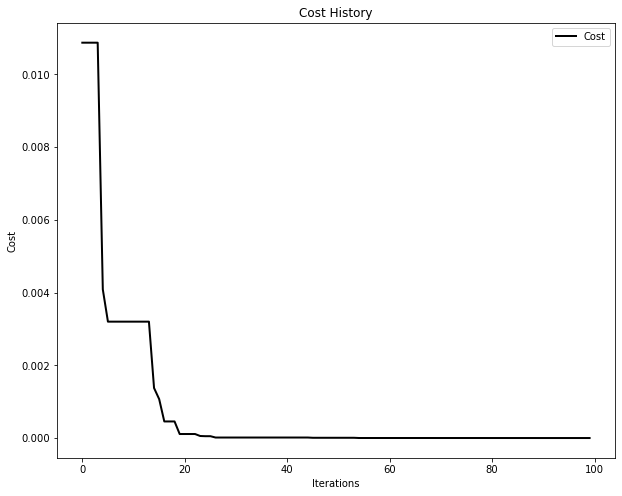

In [14]:
plot_cost_history(optimizer.cost_history)
plt.show()

In [15]:
from pyswarms.utils.plotters.formatters import Mesher
m = Mesher(func=fx.sphere)

2021-10-04 15:56:09,272 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2021-10-04 15:56:09,277 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


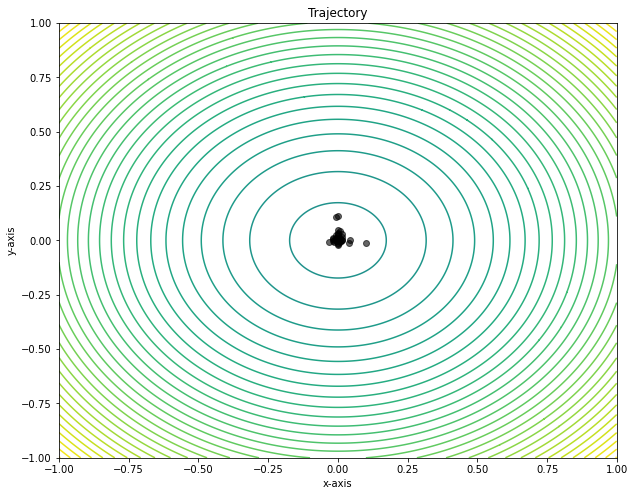

In [16]:
animation = plot_contour(pos_history=optimizer.pos_history,
                         mesher=m,
                         mark=(0,0))
animation.save('plot0.gif', writer='Pillow', fps=10)
Image(url='plot0.gif')

2021-10-04 15:58:40,450 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2021-10-04 15:58:40,450 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


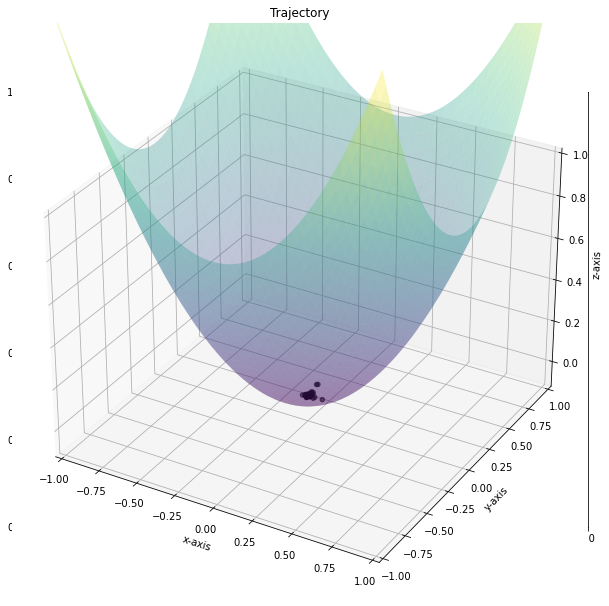

In [18]:
# Obtain a position-fitness matrix using the Mesher.compute_history_3d()
# method. It requires a cost history obtainable from the optimizer class
pos_history_3d = m.compute_history_3d(optimizer.pos_history)

# Make a designer and set the x,y,z limits to (-1,1), (-1,1) and (-0.1,1) respectively
from pyswarms.utils.plotters.formatters import Designer
d = Designer(limits=[(-1,1), (-1,1), (-0.1,1)], label=['x-axis', 'y-axis', 'z-axis'])


# Make animation
animation3d = plot_surface(pos_history=pos_history_3d, # Use the cost_history we computed
                           mesher=m, designer=d,       # Customizations
                           mark=(0,0,0))               # Mark minima

animation3d.save('plot1.gif', writer='Pillow', fps=10)
Image(url='plot1.gif')